## Multi-Mode Resource-Constrained Project Scheduling

This notebook demonstrates how to model and solve the classical Multi-Mode Resource-Constrained Project Scheduling Problem 
using Constraint Programming with IBM’s CP Optimizer via the [`docplex.cp`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/refman.html) Python API. The MMRCPSP is a generalization of the Resource-Constrained Project Scheduling problem, see [`rcpsp.ipynb`](https://github.com/radovluk/CP_Cookbook/blob/main/notebooks/rcpsp.ipynb). 

In the MMRCPSP, each task can be performed in one out of several modes. Each mode of an task represents an alternative way of combining different levels of resource requirements with a related duration. Renewable and non-renewable resources are distinguished. While renewable resources have a limited instantaneous availability such as manpower and machines, non renewable resources are limited for the entire project, allowing to model, e.g., a budget for the project. The objective is to find a mode and a start time for each task such that the schedule is makespan minimal and feasible with regard to the precedence and resource constraints.

### Problem Definition

$$
\begin{aligned}
\min \quad 
& \max_{i \in [1..N]} \mathrm{endOf}(x_i) 
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \mathrm{alternative}\!\left(x_i,\; [\,y_{ij}\,]_{j\in M[i]}\right), 
\qquad & \forall i\in[1..N] 
\quad & \text{(2)} \\[1mm]
& \sum_{i\in[1..N]}\sum_{j\in M[i]} 
  \mathrm{pulse}\!\left(y_{ij},\, \mathrm{QR}_{ijk}\right)
  \le \mathrm{CR}_k, 
\qquad & \forall k\in[1..R] 
\quad & \text{(3)} \\[1mm]
& \sum_{i\in[1..N]}\sum_{j\in M[i]} 
  \mathrm{presenceOf}(y_{ij})\cdot \mathrm{QS}_{ijk}
  \le \mathrm{CS}_k, 
\qquad & \forall k\in[1..S] 
\quad & \text{(4)} \\[1mm]
& \mathrm{endBeforeStart}(x_i, x_j), 
\qquad & \forall (i,j)\in P 
\quad & \text{(5)} \\[1mm]
& \text{interval } x_i, 
\qquad & \forall i\in[1..N] 
\quad & \text{(6)} \\[1mm]
& \text{interval } y_{ij}\ \text{optional, size}=PT_{ij}, 
\qquad & \forall i\in[1..N],\ \forall j\in M[i] 
\quad & \text{(7)}
\end{aligned}
$$


We are given:

- A finite set of **tasks** indexed by $i\in[1..N]$; each task has a **mode set** $M[i]$. Tasks can be done in different modes $j\in M[i]$.
- A finite set of **renewable resources** indexed by $k\in[1..R]$ with capacities $\mathrm{CR}_k>0$.
- A finite set of **nonrenewable (consumable) resources** indexed by $k\in[1..S]$ with capacities $\mathrm{CS}_k>0$.

Each task–mode pair $(i,j)$ with $j\in M[i]$:
- has a **processing time** $PT_{ij}>0$,
- consumes **renewable** amount $\mathrm{QR}_{ijk}\ge 0$ on each renewable $k$ while it runs,
- and **consumable** amount $\mathrm{QS}_{ijk}\ge 0$ on each nonrenewable $k$ at the project level.

There is a set of **precedence relations** $P \subseteq [1..N]\times[1..N]$,  
where $(i,j)\in P$ means task $i$ must **finish before** task $j$ **starts**.

Objective:
- **(1)** Minimize the **makespan**  $C_{\max} = \max_{i\in[1..N]} \mathrm{endOf}(x_i)$
  — i.e., finish all tasks as early as possible while satisfying constraints **(2)–(5)**.

Modeling constraints:
- **(2)** Ensures one mode $y_{ij}$ is selected for task $i$ and its timing matches $x_i$.
- **(3)** Enforces **renewable resource limits** so that, at any time, $\sum_{i,j}\mathrm{pulse}(y_{ij}, \mathrm{QR}_{ijk}) \le \mathrm{CR}_k$.
- **(4)** Enforces **nonrenewable resource limits** at the project level, $\sum_{i,j}\mathrm{presenceOf}(y_{ij}) \cdot \mathrm{QS}_{ijk} \le \mathrm{CS}_k$.
- **(5)** Maintains all **precedence relations** $(i,j)\in P$.

Variables:
- **(6)** $x_i$: a **mandatory interval** representing the execution of task $i$.  
- **(7)** $y_{ij}$: **optional intervals**, each representing task $i$ performed in **mode $j$** with fixed duration $PT_{ij}$. Each task $x_i$ must coincide with **exactly one** of its modes $y_{ij}$.


#### Note on the [`alternative()`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.alternative) function

Enforces **mode selection** for task $i$: when $x_i$ is executed, **exactly one** mode interval $y_{ij}$ is chosen (or $c$ of them with cardinality $c$), and the chosen interval(s) share the **same start and end** as $x_i$.

Mathematically (unit cardinality):
$$
\sum_{j\in M[i]} \mathrm{presenceOf}(y_{ij}) = \mathrm{presenceOf}(x_i),
\qquad
\mathrm{presenceOf}(y_{ij})=1 \Rightarrow 
\mathrm{start}(y_{ij})=\mathrm{start}(x_i),\ 
\mathrm{end}(y_{ij})=\mathrm{end}(x_i).
$$

With cardinality $c$:
$$
\sum_{j\in M[i]} \mathrm{presenceOf}(y_{ij}) = c\cdot \mathrm{presenceOf}(x_i).
$$

#### Note on the [`presenceOf()`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.presence_of) function

Is a **binary indicator** telling whether the optional interval $y_{ij}$ is in the schedule (1) or not (0); it lets you **count selections**, **sum costs/resources** only for chosen modes, and **link logic** between activities.

Formally:
$$
\mathrm{presenceOf}(y_{ij}) \in \{0,1\},\quad
\mathrm{presenceOf}(y_{ij})=1 \Leftrightarrow y_{ij}\ \text{executes}.
$$

Examples of use:
- Counting modes: $\sum_{j\in M[i]} \mathrm{presenceOf}(y_{ij})=1$.
- Nonrenewables/costs: $\sum_{i}\sum_{j\in M[i]} \mathrm{presenceOf}(y_{ij})\, \mathrm{QS}_{ijk} \le \mathrm{CS}_k$.
- Logic: $\mathrm{presenceOf}(y_{ij}) \Rightarrow \mathrm{presenceOf}(z_\ell)$.

#### Symbols and Notation

| Symbol / Function | Meaning | docplex.cp reference |
|---|---|---|
| $N$ | Number of tasks | — |
| $M[i]$ | Mode set of task $i$ | — |
| $R, S$ | Number of renewable / nonrenewable resources | — |
| $PT_{ij}$ | Duration of task $i$ in mode $j$ | — |
| $\mathrm{QR}_{ijk}$ | Renewable demand of $i$ in mode $j$ on resource $k$ | — |
| $\mathrm{QS}_{ijk}$ | Nonrenewable use of $i$ in mode $j$ on resource $k$ | — |
| $\mathrm{CR}_k, \mathrm{CS}_k$ | Capacities of renewable / nonrenewable resource $k$ | — |
| $x_i$ | **Mandatory** interval variable for task $i$ | [docplex.cp.modeler.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.interval_var) |
| $y_{ij}$ | **Optional** interval for mode $j$ of task $i$ | [docplex.cp.modeler.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.interval_var) |
| $\mathrm{alternative}(x_i,\,[y_{ij}])$ | Selects **exactly one** mode $y_{ij}$ and synchronizes it with $x_i$ | [docplex.cp.modeler.alternative](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.alternative) |
| $\mathrm{pulse}(y_{ij},\, \mathrm{QR}_{ijk})$ | Time-varying usage of renewable resource $k$ while $y_{ij}$ executes | [docplex.cp.modeler.pulse](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.pulse) |
| $\mathrm{presenceOf}(y_{ij})$ | 1 if the optional interval is present, else 0 | [docplex.cp.modeler.presence_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.presence_of) |
| $\mathrm{endBeforeStart}(x_i, x_j)$ | Enforce $x_j$ to start after $x_i$ ends | [docplex.cp.modeler.end_before_start](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_before_start) |
| $\max_i\, \mathrm{endOf}(x_i)$ | Makespan of the project | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) |
| $\min C_{\max}$ | Objective: minimize makespan | [docplex.cp.modeler.minimize](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.minimize) |


### Implementation

> This notebook is an adaptation of the *MMRCPSP* example from the [IBM Decision Optimization CPLEX Modeling for Python (DOcplex) Examples Repository](https://github.com/IBMDecisionOptimization/docplex-examples/tree/master).  

#### Imports

In [ ]:
from docplex.cp.model import *

# Needed only for visualisation
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt

#### Reading the data file

In [13]:
# Read next non empty line
def next_int_line(f):
    line = None
    while not line:
       line = f.readline().split()
    return [int(v) for v in line]

In [16]:
filename = "../data/rcpspmm/rcpspmm_default.data"

# Available files are rcpspmm_default, and different rcpspmm_XXXXXX.
# First line contains the number of tasks, the number of renewable and non-renewable resources.
# Second line contains the capacities of the renewable resources.
# Third line contains the capacities of the non_renewable resources.
# The next N lines are description of tasks, with:
# - the id of the task,
# - the number of modes for this task,
# - the number of successors followed by the list of successor numbers
# The rest of the file consists of one line per task mode, containing:
# - the id of the task (from zero)
# - the id of the mode (from 1)
# - the duration of the task in this mode
# - the demand for renewable resources
# - the demand for non-renewable resources

with open(filename, "r") as f:
    N, R, S = next_int_line(f) # N tasks, R renewables, S nonrenewables
    CR = next_int_line(f) # renewable capacities CR_k
    CS = next_int_line(f) # nonrenewable capacities CS_k

    # N task header lines: <task_id> <#modes> <#succ> <succ_1> ... <succ_ns>
    TASKS = [next_int_line(f) for _ in range(N)]

    # Number of mode lines to read = sum of #modes over tasks
    nb_mode_lines = sum(t[1] for t in TASKS)

    # Mode lines: <task_id> <mode_id> <duration> <R-demands[1..R]> <S-demands[1..S]>
    TASK_MODES = [next_int_line(f) for _ in range(nb_mode_lines)]

#### Prepare structures & notation mapping

In [19]:
# Class representing a task
class Task:
    def __init__(self, tid, nb_modes):
        self.tid = tid
        self.nb_modes = nb_modes
        self.successors = []
        self.modes = []  # list of Mode

# Class representing a mode
class Mode:
    def __init__(self, tid, mid, duration, dem_R, dem_S):
        self.tid = tid
        self.mid = mid
        self.duration = duration
        self.QR = dem_R[:]  # renewable usage vector (length R)
        self.QS = dem_S[:]  # nonrenewable usage vector (length S)

Solving model...
 ! --------------------------------------------------- CP Optimizer 22.1.2.0 --
 ! Minimization problem - 136 variables, 94 constraints
 ! FailLimit            = 30000
 ! TimeLimit            = 10
 ! Initial process time : 0.01s (0.00s extraction + 0.01s propagation)
 !  . Log search space  : 306.8 (before), 306.8 (after)
 !  . Memory usage      : 968.3 kB (before), 968.3 kB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        136                 -
 + New bound is 38
 ! Using iterative diving.
 *            86       75  0.13s        1      (gap is 55.81%)
 *            83      265  0.13s        1      (gap is 54.22%)
 *            82      439  0.13s        1      (gap is 53.66%)
 *            81      513  0.13s        1      (gap is 53.09%)
 *            75      587  0.13s        1      (gap is 49.

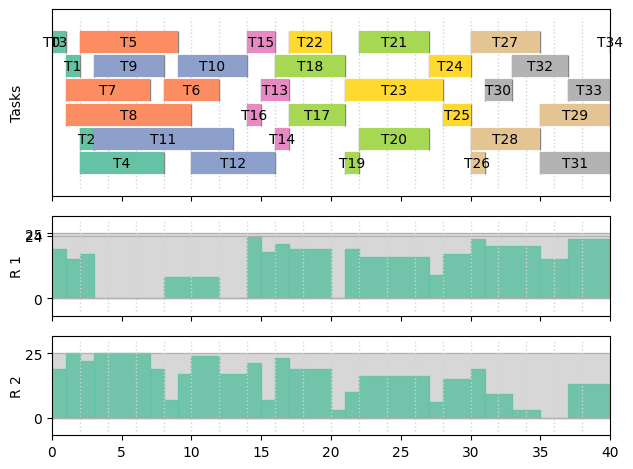

In [2]:
# --------------------------------------------------------------------------
# Source file provided under Apache License, Version 2.0, January 2004,
# http://www.apache.org/licenses/
# (c) Copyright IBM Corp. 2015, 2022
# --------------------------------------------------------------------------

"""
The MMRCPSP (Multi-Mode Resource-Constrained Project Scheduling Problem) is a
generalization of the Resource-Constrained Project Scheduling problem
(see rcpsp.py).

In the MMRCPSP, each activity can be performed in one out of several modes.
Each mode of an activity represents an alternative way of combining different levels
of resource requirements with a related duration.
Renewable and non-renewable resources are distinguished.
While renewable resources have a limited instantaneous availability such as
manpower and machines, non renewable resources are limited for the entire project,
allowing to model, e.g., a budget for the project.

The objective is to find a mode and a start time for each activity such that the
schedule is makespan minimal and feasible with regard to the precedence
and resource constraints.

Please refer to documentation for appropriate setup of solving configuration.
"""

from docplex.cp.model import *
import os

#-----------------------------------------------------------------------------
# Initialize the problem data
#-----------------------------------------------------------------------------

# Read next non empty line
def next_int_line(f):
    line = None
    while not line:
       line = f.readline().split()
    return [int(v) for v in line]

# Read the input data file.
# Available files are rcpspmm_default, and different rcpspmm_XXXXXX.
# First line contains the number of tasks, the number of renewable and non-renewable resources.
# Second line contains the capacities of the renewable resources.
# Third line contains the capacities of the non_renewable resources.
# The next nb_task lines are description of tasks, with:
# - the id of the task,
# - the number of modes for this task,
# - the number of successors followed by the list of successor numbers
# The rest of the file consists of one line per task mode, containing:
# - the id of the task (from zero)
# - the id of the mode (from 1)
# - the duration of the task in this mode
# - the demand for renewable resources
# - the demand for non-renewable resources

# filename = os.path.dirname(os.path.abspath(__file__)) + '/data/rcpspmm_default.data'
filename = "../data/rcpspmm/rcpspmm_default.data"
with open(filename, 'r') as file:
    NB_TASKS, NB_RENEWABLE, NB_NON_RENEWABLE = next_int_line(file)
    CAPACITIES_RENEWABLE = next_int_line(file)
    CAPACITIES_NON_RENEWABLE = next_int_line(file)
    TASKS = [next_int_line(file) for i in range(NB_TASKS)]
    TASK_MODES = [next_int_line(file) for i in range(sum([t[1] for t in TASKS]))]


#-----------------------------------------------------------------------------
# Prepare the data for modeling
#-----------------------------------------------------------------------------

# Object class representing a task
class Task(object):
    def __init__(self, name, nb_modes):
        super(Task, self).__init__()
        self.name = name
        self.nb_modes = nb_modes
        self.successors = []
        self.modes = []

# Object class representing a mode
class Mode(object):
    def __init__(self, name, task, duration, dem_renewables, dem_non_renewables):
        super(Mode, self).__init__()
        self.name = name
        self.task = task
        self.duration = duration
        self.demand_renewable = dem_renewables
        self.demand_non_renewable = dem_non_renewables


# Build list of tasks
tasks_data = []
for i, t in enumerate(TASKS):
    task = Task('T{}'.format(i), t[1])
    for j in range(t[2]):
        task.successors.append(t[3 + j])
    tasks_data.append(task)

# Build list of modes
modes_data = []
for m in TASK_MODES:
    taskid = m[0]
    modeid = m[1]
    dur = m[2]
    dem_renewables = m[3 : 3 + NB_RENEWABLE]
    dem_non_renewables = m[3 + NB_RENEWABLE : 3 + NB_RENEWABLE + NB_NON_RENEWABLE]
    mode = Mode('T{}-M{}'.format(taskid, modeid),
                tasks_data[taskid], dur, dem_renewables, dem_non_renewables)
    tasks_data[taskid].modes.append(mode)
    modes_data.append(mode)


#-----------------------------------------------------------------------------
# Build the model
#-----------------------------------------------------------------------------

# Create model
mdl = CpoModel()

# Create one interval variable per task
tasks = { t: mdl.interval_var(name=t.name) for t in tasks_data}

# Add precedence constraints
mdl.add(end_before_start(tasks[t], tasks[tasks_data[s]]) for t in tasks_data for s in t.successors)

# Create one optional interval variable per mode
modes = { m: interval_var(name=m.name, optional=True, size=m.duration) for m in modes_data}

# Add mode alternative for each task
mdl.add(alternative(tasks[t], [modes[m] for m in t.modes]) for t in tasks_data)

# Initialize cumul functions for renewable and non renewable resources
renewables     = [ sum(pulse(modes[m], m.demand_renewable[j]) for m in modes_data if m.demand_renewable[j] > 0)
                   for j in range(NB_RENEWABLE)]
non_renewables = [ sum(m.demand_non_renewable[j]*presence_of(modes[m]) for m in modes_data if m.demand_non_renewable[j] > 0 )
                   for j in range(NB_NON_RENEWABLE)]

# Constrain renewable resources capacity
mdl.add(renewables[j] <= CAPACITIES_RENEWABLE[j]  for j in range(NB_RENEWABLE))

# Constrain non-renewable resources capacity
mdl.add(non_renewables[j] <= CAPACITIES_NON_RENEWABLE[j]  for j in range(NB_NON_RENEWABLE))

# Minimize overall schedule end date
mdl.add(minimize(max([end_of(tasks[t]) for t in tasks_data])))


#-----------------------------------------------------------------------------
# Solve the model and display the result
#-----------------------------------------------------------------------------

# Solve model
print('Solving model...')
res = mdl.solve(FailLimit=30000, TimeLimit=10)
print('Solution: ')
res.print_solution()

import docplex.cp.utils_visu as visu
if res and visu.is_visu_enabled():
    load = [CpoStepFunction() for j in range(NB_RENEWABLE)]
    for m in modes_data:
        itv = res.get_var_solution(modes[m])
        if itv.is_present():
            for j in range(NB_RENEWABLE):
                if 0 < m.demand_renewable[j]:
                    load[j].add_value(itv.get_start(), itv.get_end(), m.demand_renewable[j])

    visu.timeline('Solution for RCPSPMM ' + filename)
    visu.panel('Tasks')
    for t in tasks_data:
        visu.interval(res.get_var_solution(tasks[t]), int(t.name[1:]), t.name)
    for j in range(NB_RENEWABLE):
        visu.panel('R ' + str(j + 1))
        visu.function(segments=[(INTERVAL_MIN, INTERVAL_MAX, CAPACITIES_RENEWABLE[j])], style='area', color='lightgrey')
        visu.function(segments=load[j], style='area', color=j)
    visu.show()
